In [ ]:
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [2]:
from unsloth import FastVisionModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [3]:
model, tokenizer = FastVisionModel.from_pretrained(
    model_name="unsloth/Qwen2-VL-7B-Instruct",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth"
)

==((====))==  Unsloth 2025.7.11: Fast Qwen2_Vl patching. Transformers: 4.54.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

In [4]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers=True,
    finetune_language_layers=True,
    finetune_attention_modules=True,
    finetune_mlp_modules=True,

    r=16,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    random_state=3407,
    use_rslora=False,
    loftq_config=None
)

In [5]:
from datasets import load_dataset
dataset = load_dataset('unsloth/Latex_OCR', split='train')

README.md:   0%|          | 0.00/519 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/344M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/68686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7632 [00:00<?, ? examples/s]

In [6]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 68686
})

In [7]:
dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>,
 'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}

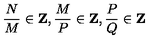

In [8]:
dataset[0]['image']

In [9]:
instruction = "Write the LaTex representation of this image"

In [10]:
def convert_to_conversation(sample):
  conversation = [
      {"role":"user",
       "content":[
           {"type":"text", "text": instruction},
           {"type":"image", "image":sample['image']},
       ]
      },
      {"role":"assistant",
       "content":[
           {"type":"text", "text": sample['text']},
       ]
      },
  ]
  return {"messages": conversation}

In [11]:
convert_to_conversation(dataset[0])

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation of this image'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=160x40>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '{ \\frac { N } { M } } \\in { \\bf Z } , { \\frac { M } { P } } \\in { \\bf Z } , { \\frac { P } { Q } } \\in { \\bf Z }'}]}]}

In [12]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

In [13]:
converted_dataset[1]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'Write the LaTex representation of this image'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x50>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'D _ { \\mu } ^ { \\alpha \\beta } \\bar { A } _ { \\mu } ^ { \\alpha \\beta } = 0 ,'}]}]}

In [14]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=Fals

## Inferencing Before Finetuning

In [15]:
image = dataset[1]['image']
messages = [
    {
        "role":"user",
        "content":[
            {"type":"text", "text": instruction},
            {"type":"image", "image":image},
        ]
    }
]

In [16]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image, input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to("cuda")

In [17]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens= 128, use_cache=True, temperature=1.5, min_p=0.1)

The LaTeX representation of the image is:

```latex
D^{\mu}_{\mu} \tilde{A}^{\mu}_{\mu} = 0,
```<|im_end|>


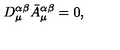

In [18]:
image   ## Compeletely Wrong (above generated)

In [19]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

In [20]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=Fals

In [21]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = converted_dataset,

    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        output_dir = "output",
        optim = "adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type = "linear",
        seed=3047,
        report_to="none",
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc=4,
    )
)

Unsloth: Model does not have a default image size - using 512


In [22]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 68,686 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 50,855,936 of 8,342,231,552 (0.61% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.155900
2,1.289800
3,1.406400
4,0.968100
5,0.874900
6,0.861600
7,0.686800
8,0.447800
9,0.301300
10,0.342900


TrainOutput(global_step=30, training_loss=0.38814643944303195, metrics={'train_runtime': 233.5093, 'train_samples_per_second': 1.028, 'train_steps_per_second': 0.128, 'total_flos': 1661933681209344.0, 'train_loss': 0.38814643944303195})

In [23]:
FastVisionModel.for_inference(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2VLForConditionalGeneration(
      (model): Qwen2VLModel(
        (visual): Qwen2VisionTransformerPretrainedModel(
          (patch_embed): PatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-18): 19 x Qwen2VLVisionBlock(
              (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
              (attn): VisionAttention(
                (qkv): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3840, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=16, bias=Fals

In [24]:
image = dataset[2]["image"]

In [25]:
instructions = "Write the LaTex representation of this image"

In [26]:
messages = [
    {
        "role":"user",
        "content":[
            {"type":"text", "text": instruction},
            {"type":"image", "image":image},
        ]
    }
]

In [27]:
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image, input_text,
    add_special_tokens=False,
    return_tensors="pt"
).to("cuda")

In [28]:
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(**inputs, streamer=text_streamer, max_new_tokens= 128, use_cache=True, temperature=1.5, min_p=0.1)

H ^ { \prime } = \beta N \int d \lambda \left\{ \frac { 1 } { 2 \beta ^ { 2 } N ^ { 2 } } \partial _ { \lambda } \xi ^ { \dagger } \partial _ { \lambda } \xi + V ( \lambda ) \xi ^ { \dagger } \xi \right\} \ .<|im_end|>


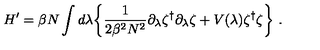

In [29]:
image